In [1]:
import numpy as np  # for array
import pandas as pd  # for csv files and dataframe
import matplotlib.pyplot as plt  # for plotting
import seaborn as sns  # plotting
from scipy import stats

import pickle  # To load data int disk
from prettytable import PrettyTable  # To print in tabular format

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer
from sklearn.metrics import auc, f1_score, roc_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_validate, cross_val_predict

%matplotlib inline

In [2]:
saved_info = {}
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
path="/home/dezs/projects/myIDS/datasets/"

In [4]:
# Reading datasets
dfs = []
for i in range(1,5):
    path2 = path+'UNSW-NB15/UNSW-NB15_{}.csv'  # There are 4 input csv files
    dfs.append(pd.read_csv(path2.format(i), header = None))
all_data = pd.concat(dfs).reset_index(drop=True)  # Concat all to a single df

In [5]:
all_data.head()

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,59.166.0.0,1390,149.171.126.6,53,udp,CON,0.001055,132,164,31,...,0,3,7,1,3,1,1,1,NaN,0
1,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528,304,31,...,0,2,4,2,3,1,1,2,NaN,0
2,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146,178,31,...,0,12,8,1,2,2,1,1,NaN,0
3,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132,164,31,...,0,6,9,1,1,1,1,1,NaN,0
4,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146,178,31,...,0,7,9,1,1,1,1,1,NaN,0


In [6]:
df_col = pd.read_csv(path+'UNSW-NB15/NUSW-NB15_features.csv', encoding='ISO-8859-1')

In [7]:
df_col['Name'] = df_col['Name'].apply(lambda x: x.strip().replace(' ', '').lower())

In [8]:
all_data.columns=df_col['Name']

In [9]:
all_data.head()

Name,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,label
0,59.166.0.0,1390,149.171.126.6,53,udp,CON,0.001055,132,164,31,...,0,3,7,1,3,1,1,1,NaN,0
1,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528,304,31,...,0,2,4,2,3,1,1,2,NaN,0
2,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146,178,31,...,0,12,8,1,2,2,1,1,NaN,0
3,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132,164,31,...,0,6,9,1,1,1,1,1,NaN,0
4,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146,178,31,...,0,7,9,1,1,1,1,1,NaN,0


In [10]:
all_data.columns.to_list()

['srcip',
 'sport',
 'dstip',
 'dsport',
 'proto',
 'state',
 'dur',
 'sbytes',
 'dbytes',
 'sttl',
 'dttl',
 'sloss',
 'dloss',
 'service',
 'sload',
 'dload',
 'spkts',
 'dpkts',
 'swin',
 'dwin',
 'stcpb',
 'dtcpb',
 'smeansz',
 'dmeansz',
 'trans_depth',
 'res_bdy_len',
 'sjit',
 'djit',
 'stime',
 'ltime',
 'sintpkt',
 'dintpkt',
 'tcprtt',
 'synack',
 'ackdat',
 'is_sm_ips_ports',
 'ct_state_ttl',
 'ct_flw_http_mthd',
 'is_ftp_login',
 'ct_ftp_cmd',
 'ct_srv_src',
 'ct_srv_dst',
 'ct_dst_ltm',
 'ct_src_ltm',
 'ct_src_dport_ltm',
 'ct_dst_sport_ltm',
 'ct_dst_src_ltm',
 'attack_cat',
 'label']

In [11]:
saved_info["columns"]=df_col['Name'][df_col['Name']!='attack_cat'].tolist()

In [12]:
del df_col

In [13]:
all_data['attack_cat'] = all_data.attack_cat.fillna(value='normal').apply(lambda x: x.strip().lower())

In [14]:
all_data['ct_flw_http_mthd'] = all_data.ct_flw_http_mthd.fillna(value=0)

In [15]:
all_data['is_ftp_login'] = (all_data.is_ftp_login.fillna(value=0)).astype(int)

In [16]:
all_data.shape

(2540047, 49)

In [17]:
all_data = all_data.drop_duplicates(keep='first')

In [18]:
all_data.shape

(2059417, 49)

In [23]:
all_data['attack_cat'] = all_data['attack_cat'].replace('backdoors','backdoor', regex=True).apply(lambda x: x.strip().lower())

In [24]:
all_data['attack_cat'].value_counts()

attack_cat
normal            1959772
exploits            27599
generic             25378
fuzzers             21795
reconnaissance      13357
dos                  5665
analysis             2185
backdoor             1984
shellcode            1511
worms                 171
Name: count, dtype: int64

In [25]:
all_data['attack_cat'].value_counts()/len(all_data)*100

attack_cat
normal            95.161495
exploits           1.340137
generic            1.232290
fuzzers            1.058309
reconnaissance     0.648582
dos                0.275078
analysis           0.106098
backdoor           0.096338
shellcode          0.073370
worms              0.008303
Name: count, dtype: float64

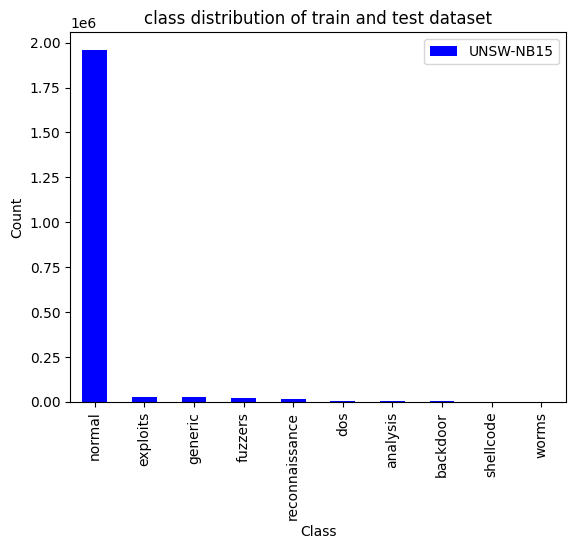

In [26]:
plt.figure()
plt.title("class distribution of train and test dataset")
all_data['attack_cat'].value_counts().plot(kind="bar", color='b', label="UNSW-NB15")
plt.xlabel("Class")
plt.ylabel("Count")
plt.legend()
plt.show()

In [18]:
train,test=train_test_split(all_data,test_size=0.3,random_state=1)

In [19]:
del all_data

In [20]:
print(train.shape,'\n',test.shape)

(1441591, 49) 
 (617826, 49)


In [21]:
train.isnull().sum()

Name
srcip               0
sport               0
dstip               0
dsport              0
proto               0
state               0
dur                 0
sbytes              0
dbytes              0
sttl                0
dttl                0
sloss               0
dloss               0
service             0
sload               0
dload               0
spkts               0
dpkts               0
swin                0
dwin                0
stcpb               0
dtcpb               0
smeansz             0
dmeansz             0
trans_depth         0
res_bdy_len         0
sjit                0
djit                0
stime               0
ltime               0
sintpkt             0
dintpkt             0
tcprtt              0
synack              0
ackdat              0
is_sm_ips_ports     0
ct_state_ttl        0
ct_flw_http_mthd    0
is_ftp_login        0
ct_ftp_cmd          0
ct_srv_src          0
ct_srv_dst          0
ct_dst_ltm          0
ct_src_ltm          0
ct_src_dport_ltm    0
ct_ds

In [22]:
train['attack_cat'].value_counts()

attack_cat
normal            1371997
exploits            19447
generic             17691
fuzzers             15175
reconnaissance       9297
dos                  3970
analysis             1488
backdoor             1159
shellcode            1039
backdoors             215
worms                 113
Name: count, dtype: int64

In [23]:
train['attack_cat'].value_counts()/len(train)*100

attack_cat
normal            95.172417
exploits           1.348996
generic            1.227186
fuzzers            1.052656
reconnaissance     0.644912
dos                0.275390
analysis           0.103219
backdoor           0.080397
shellcode          0.072073
backdoors          0.014914
worms              0.007839
Name: count, dtype: float64

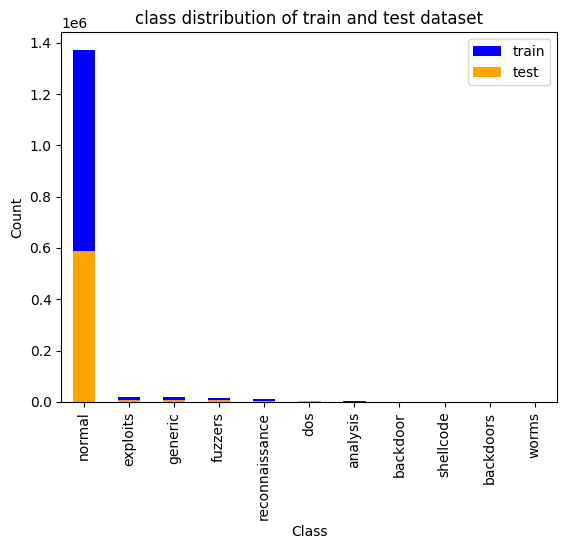

In [24]:
plt.figure()
plt.title("class distribution of train and test dataset")
train['attack_cat'].value_counts().plot(kind="bar", color='b', label="train")
test['attack_cat'].value_counts().plot(kind="bar", color='orange', label="test")
plt.xlabel("Class")
plt.ylabel("Count")
plt.legend()
plt.show()

In [25]:
train.dtypes.value_counts()

int64      29
float64    11
object      9
Name: count, dtype: int64

In [26]:
train.select_dtypes(include='object').columns.tolist()

['srcip',
 'sport',
 'dstip',
 'dsport',
 'proto',
 'state',
 'service',
 'ct_ftp_cmd',
 'attack_cat']

In [27]:
train.select_dtypes(include=np.number).columns.tolist()

['dur',
 'sbytes',
 'dbytes',
 'sttl',
 'dttl',
 'sloss',
 'dloss',
 'sload',
 'dload',
 'spkts',
 'dpkts',
 'swin',
 'dwin',
 'stcpb',
 'dtcpb',
 'smeansz',
 'dmeansz',
 'trans_depth',
 'res_bdy_len',
 'sjit',
 'djit',
 'stime',
 'ltime',
 'sintpkt',
 'dintpkt',
 'tcprtt',
 'synack',
 'ackdat',
 'is_sm_ips_ports',
 'ct_state_ttl',
 'ct_flw_http_mthd',
 'is_ftp_login',
 'ct_srv_src',
 'ct_srv_dst',
 'ct_dst_ltm',
 'ct_src_ltm',
 'ct_src_dport_ltm',
 'ct_dst_sport_ltm',
 'ct_dst_src_ltm',
 'label']

In [28]:
train['ct_ftp_cmd'] = train['ct_ftp_cmd'].replace(to_replace=' ', value=0).astype(int)

In [29]:
saved_info['binary_col'] = ['is_sm_ips_ports', 'is_ftp_login']

In [30]:
train['is_ftp_login'] = np.where(train['is_ftp_login']>1, 1, train['is_ftp_login'])

In [31]:
train['service'] = train['service'].apply(lambda x:"none" if x=="-" else x)

In [32]:
train['attack_cat'] = train['attack_cat'].replace('backdoors','backdoor', regex=True).apply(lambda x: x.strip().lower())

In [33]:
# train.to_csv(path+'train_clean.csv', index=False)
# test.to_csv(path+'test_clean.csv', index=False)
# pickle.dump(saved_info, open(path+'saved_infos.pkl', 'wb'))